In [1]:
import os
from glob     import glob
from datetime import datetime

import numpy  as np
import pandas as pd

import matplotlib.pyplot as plt

from CCdb   import _default_reference_file as references

from CCio   import load_hdf

from CCcore import in_range
from CCcore import rebin_df
from CCcore import filter_df
from CCcore import histogram
from CCcore import integrate_peak
from CCcore import power_to_quanta_rate
from CCcore import fix_hot_pixel

from CCfit  import fit
from CCfit  import gauss

from CCplot import change_jupyter_width
from CCplot import auto_plot_style
from CCplot import figure
from CCplot import subplot
from CCplot import labels
from CCplot import normhist
from CCplot import plot1d
from CCplot import plot2d

In [2]:
exec(change_jupyter_width(90))

In [3]:
%matplotlib inline

auto_plot_style()

In [4]:
_default_column = "rate"

In [5]:
def remove_duplicate_grating(df):
    sel = (df.ex_wl == 400) & (df.grating_mono == 1)
    return df.loc[~sel].reset_index(drop=True)

def load(filename, crystal):
    df = load_hdf(filename, crystal)
    fix_hot_pixel(df)
    return df

def timestamp_from_folder(folder):
    folder = os.path.basename(folder)
    tokens= map(int, folder.split(".")[0].split("_")[5:])
    return datetime(*tokens).timestamp()
    
def plot_comparison_2d(df1, df2, exposure, column=_default_column):
    figure(3)
    n = 1
    for label, df in dict(before=df1, after=df2).items():
        subplot(3, n); n+=1
        df = filter_df(df, exposure=exposure)
        df = remove_duplicate_grating(df)
        spectrum = getattr(df, column)
        s, c = plot2d(df.ex_wl, df.em_wl, spectrum, title=label
                     , log=True, zlabel=column
                     , cmin=np.percentile(spectrum, 5), cmax=spectrum.max())

    subplot(3, n); n+=1
    df1 = filter_df(remove_duplicate_grating(df1), exposure=exposure)
    df2 = filter_df(remove_duplicate_grating(df2), exposure=exposure)

    spectrum = getattr(df2, column).values - getattr(df1, column).values
    s, c = plot2d(df1.ex_wl, df1.em_wl, spectrum, title="diff"
                 , zlabel=column
                 , cmin=-5, cmax=np.percentile(spectrum, 99))
    

    plt.tight_layout()

def plot_comparison_1d_array(df1, df2, exposure, column=_default_column):
    plt.figure(figsize=(6*4, 3*14))
    df1 = remove_duplicate_grating(df1)
    df2 = remove_duplicate_grating(df2)
    for label, df in dict(before=df1, after=df2).items():
        for ex_wl, data in filter_df(df, exposure=exposure).groupby("ex_wl"):
            plt.subplot(14, 4, (ex_wl - 240) // 10)
            spectrum = getattr(data, column)
            plot1d(data.em_wl, spectrum, title=str(ex_wl), ylabel=column, label=label)

            if label=="after":
                plt.fill_betweenx(plt.ylim(), ex_wl - 10, ex_wl + 10, color="y", alpha=0.5)
                if ex_wl == 250:
                    plt.legend()

            wlmin = np.round(data.em_wl.min(), -2)
            wlmax = np.round(data.em_wl.max(), -2) + 1
            ticks = np.concatenate([ np.arange(wlmin, 1000, 200)
                                   , np.arange(1000, wlmax, 200)])

            plt.xticks(ticks)
    plt.tight_layout()
    
def integrate(wls, spectrum, wl_min, wl_max):
    sel = in_range(wls, wl_min, wl_max)
    return spectrum[sel].sum()

def ticks(wls):
    min = np.ceil (wls.min() / 100) * 100
    max = np.floor(wls.max() / 100) * 100
    return np.arange(min, max + 1, 100)

def plot_integrate(datas, crystal, ex_wl, exposure, ilimits, ylimits, rebin=4):
    ints = []
    for k, data in enumerate(datas):
        data     = filter_df(data, exposure=exposure, ex_wl=ex_wl, grating_mono = 1 + int(ex_wl >= 400))
        integral = integrate(data.em_wl, data.rate / normalization(data.timestamp), *ilimits)

        data = rebin_df(data, rebin)
        plot1d(data.em_wl, data.rate / normalization(data.timestamp), ylabel="Rate (a.u.)", label=str(k))
        ints.append(integral)
        if k==0:
            tcks = ticks(data.em_wl)

    plt.title(f"{crystal} @ {ex_wl} nm, {exposure:.1f} s")
    plt.ylim(ylimits)
    plt.vlines(ilimits, *plt.ylim(), colors="g", ls="--")
    plt.xticks(tcks)
    plt.grid()
    plt.legend()

    return ints

def plot_dose(dose, signal, crystal, ex, em, cumulative=False):
    dose = np.append([0], dose)
    if cumulative:
        dose = np.cumsum(dose)
        xlabel = "Cumulative dose (Gy)"
    else:
        xlabel = "Dose (Gy)"
        
    plt.plot(dose, signal, ".:")
    plt.xlabel(xlabel)
    plt.ylabel("Signal strength (a.u.)")
    if min(signal)>0:
        plt.ylim(0)
    plt.title (f"{crystal} ({ex}, {em})")

In [6]:
folder = "/home/gonzalo/data/CC/pre-annealing-experiment/"


caf_filename_irrad0 = os.path.join(folder, "scan_irrad0_CaF_B3_400_2021_04_28_16_57_06_172600.h5")
baf_filename_irrad0 = os.path.join(folder, "scan_irrad0_BaF_B3_420_2021_04_29_16_23_33_813600.h5")
qtz_filename_irrad0 = os.path.join(folder, "scan_irrad0_Qz_B3_440_2021_04_29_17_45_21_261600.h5" )
lif_filename_irrad0 = os.path.join(folder, "scan_irrad0_LiF_B3_460_2021_04_29_19_07_10_248600.h5")
mgf_filename_irrad0 = os.path.join(folder, "scan_irrad0_MgF_B3_480_2021_05_02_14_28_52_681000.h5")

caf_filename_irrad1 = os.path.join(folder, "scan_irrad1_CaF_B3_400_2021_05_04_12_39_56_423000.h5")
baf_filename_irrad1 = os.path.join(folder, "scan_irrad1_BaF_B3_420_2021_05_05_14_36_49_219000.h5")
qtz_filename_irrad1 = os.path.join(folder, "scan_irrad1_Qz_B3_440_2021_05_10_12_06_42_598000.h5" )
lif_filename_irrad1 = os.path.join(folder, "scan_irrad1_LiF_B3_460_2021_05_06_12_05_09_231000.h5")
mgf_filename_irrad1 = os.path.join(folder, "scan_irrad1_MgF_B3_480_2021_05_11_14_16_45_448000.h5")

caf_filename_irrad2 = os.path.join(folder, "scan_irrad2_CaF_B3_400_2021_05_30_12_45_25_178000.h5")
baf_filename_irrad2 = os.path.join(folder, "scan_irrad2_BaF_B3_420_2021_05_20_16_36_41_679000.h5")
qtz_filename_irrad2 = os.path.join(folder, "scan_irrad2_Qz_B3_440_2021_05_25_14_47_50_004000.h5" )
lif_filename_irrad2 = os.path.join(folder, "scan_irrad2_LiF_B3_460_2021_05_13_14_23_57_501000.h5")
mgf_filename_irrad2 = os.path.join(folder, "scan_irrad2_MgF_B3_480_2021_06_07_14_03_14_073000.h5")

caf_filename_irrad3 = os.path.join(folder, "scan_irrad3_CaF_B3_400_2021_07_04_16_14_31_155000.h5")
baf_filename_irrad3 = os.path.join(folder, "scan_irrad3_BaF_B3_420_2021_07_04_18_09_18_697000.h5")
qtz_filename_irrad3 = os.path.join(folder, "scan_irrad3_Qz_B3_440_2021_07_04_19_31_08_898000.h5" )
lif_filename_irrad3 = os.path.join(folder, "scan_irrad3_LiF_B3_460_2021_07_04_20_51_52_089000.h5")
mgf_filename_irrad3 = os.path.join(folder, "scan_irrad3_MgF_B3_480_2021_07_05_12_33_08_599000.h5")

caf_filename_irrad4 = os.path.join(folder, "scan_irrad4_CaF_B3_400_2021_07_19_11_23_40_605000.h5")
baf_filename_irrad4 = os.path.join(folder, "scan_irrad4_BaF_B3_420_2021_07_19_14_16_32_375000.h5")
qtz_filename_irrad4 = os.path.join(folder, "scan_irrad4_Qz_B3_440_2021_07_19_17_02_04_484000.h5" )
lif_filename_irrad4 = os.path.join(folder, "scan_irrad4_LiF_B3_460_2021_07_19_12_47_32_866000.h5")
mgf_filename_irrad4 = os.path.join(folder, "scan_irrad4_MgF_B3_480_2021_07_19_15_36_57_594000.h5")

caf_filename_irrad5 = os.path.join(folder, "scan_irrad5_CaF_B3_400_2021_07_26_20_31_08_707000.h5")
baf_filename_irrad5 = os.path.join(folder, "scan_irrad5_BaF_B3_420_2021_07_26_17_30_58_130000.h5")
qtz_filename_irrad5 = os.path.join(folder, "scan_irrad5_Qz_B3_440_2021_07_26_18_53_34_438000.h5" )
lif_filename_irrad5 = os.path.join(folder, "scan_irrad5_LiF_B3_460_2021_07_26_13_58_46_081000.h5")
mgf_filename_irrad5 = os.path.join(folder, "scan_irrad5_MgF_B3_480_2021_07_26_15_59_47_127000.h5")

caf_filename_irrad6 = os.path.join(folder, "scan_irrad6_CaF_B3_400_2021_08_02_18_51_55_584000.h5")
baf_filename_irrad6 = os.path.join(folder, "scan_irrad6_BaF_B3_420_2021_08_02_14_44_13_713000.h5")
qtz_filename_irrad6 = os.path.join(folder, "scan_irrad6_Qz_B3_440_2021_08_02_17_29_57_980000.h5" )
lif_filename_irrad6 = os.path.join(folder, "scan_irrad6_LiF_B3_460_2021_08_02_16_09_37_617000.h5")
mgf_filename_irrad6 = os.path.join(folder, "scan_irrad6_MgF_B3_480_2021_08_02_13_19_43_879000.h5")

baf_filenames = baf_filename_irrad0, baf_filename_irrad1, baf_filename_irrad2, baf_filename_irrad3, baf_filename_irrad4, baf_filename_irrad5, baf_filename_irrad6,
qtz_filenames = qtz_filename_irrad0, qtz_filename_irrad1, qtz_filename_irrad2, qtz_filename_irrad3, qtz_filename_irrad4, qtz_filename_irrad5, qtz_filename_irrad6,
lif_filenames = lif_filename_irrad0, lif_filename_irrad1, lif_filename_irrad2, lif_filename_irrad3, lif_filename_irrad4, lif_filename_irrad5, lif_filename_irrad6,
mgf_filenames = mgf_filename_irrad0, mgf_filename_irrad1, mgf_filename_irrad2, mgf_filename_irrad3, mgf_filename_irrad4, mgf_filename_irrad5, mgf_filename_irrad6,

In [7]:
dose_filename = "/home/gonzalo/data/CC/pre-annealing-experiment/sim/total_dose.h5"
dose = pd.read_hdf(dose_filename, "/dose").set_index("crystal")
#dose = dose.loc[dose.irrad_no <= 5]

# Power corrections

In [8]:
from scipy.interpolate import interp1d

df = pd.read_hdf("/home/gonzalo/data/CC/pre-annealing-experiment/power_normalization.h5", "/integrals")
df = df.assign(norm = df.integral / df.integral.max() )

normalization = interp1d(df.timestamp, df.norm)
#normalization = lambda x: np.ones_like(x)

# BaF

In [9]:
crystal = "BaF"
datas = list(map(lambda x: load(x, crystal), baf_filenames))

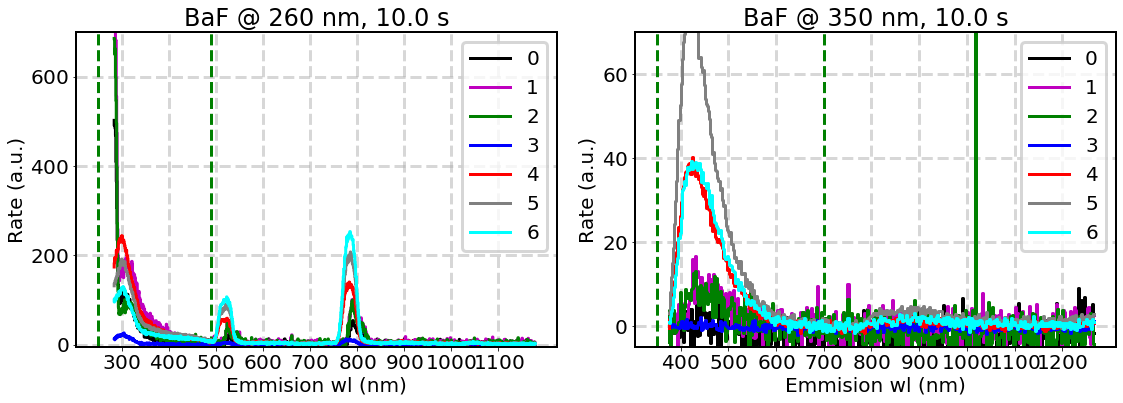

In [10]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
baf_260_300 = plot_integrate(datas, crystal, 260, 10, (250, 490), (-5, 700), rebin=2)

plt.subplot(1, 2, 2)
baf_350_450 = plot_integrate(datas, crystal, 350, 10, (350, 700), (-5, 70), rebin=5)

plt.tight_layout()

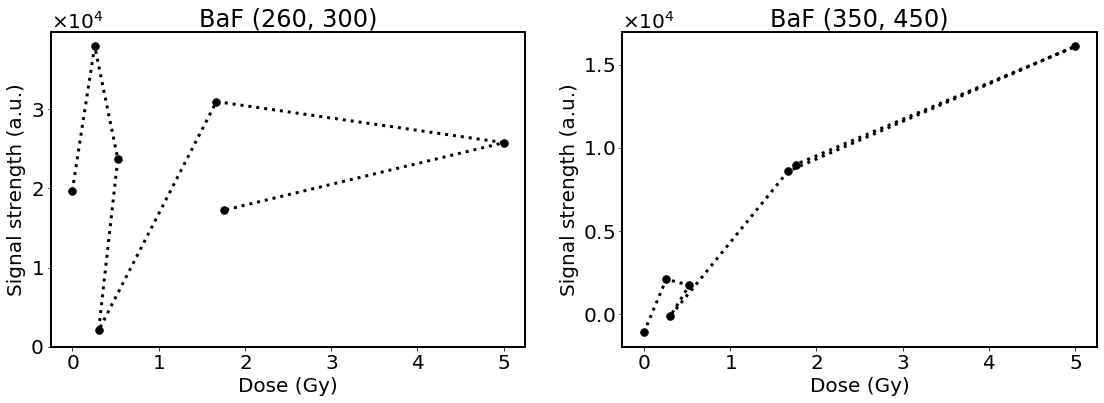

In [11]:
plt.figure(figsize=(16, 6))
d = dose.loc["BaF"].dose

plt.subplot(1, 2, 1)
plot_dose(d, baf_260_300, "BaF", 260, 300)

plt.subplot(1, 2, 2)
plot_dose(d, baf_350_450, "BaF", 350, 450)

plt.tight_layout()

# Qtz

In [12]:
crystal = "Qz"
datas = list(map(lambda x: load(x, crystal), qtz_filenames))

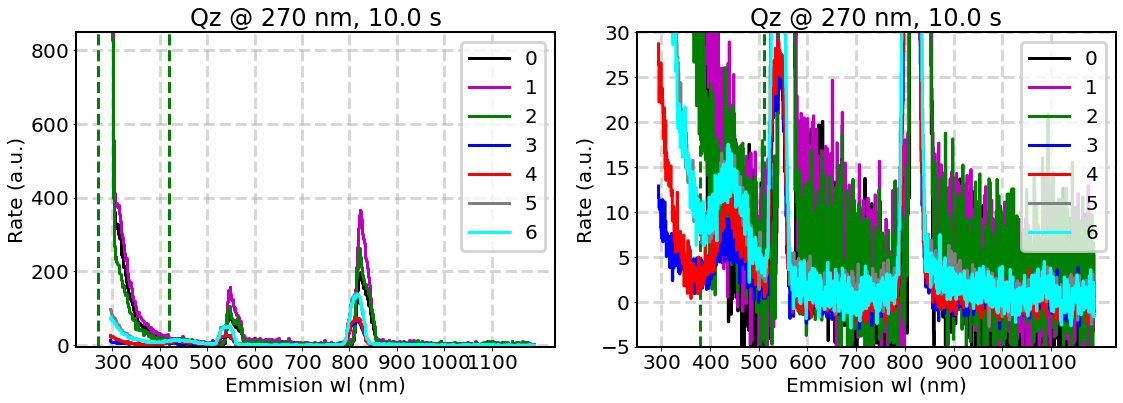

In [13]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
qtz_270_270 = plot_integrate(datas, crystal, 270, 10, (270, 420), (-5, 850))

plt.subplot(1, 2, 2)
qtz_270_450 = plot_integrate(datas, crystal, 270, 10, (380, 510), (-5, 30), rebin=2)

plt.tight_layout()

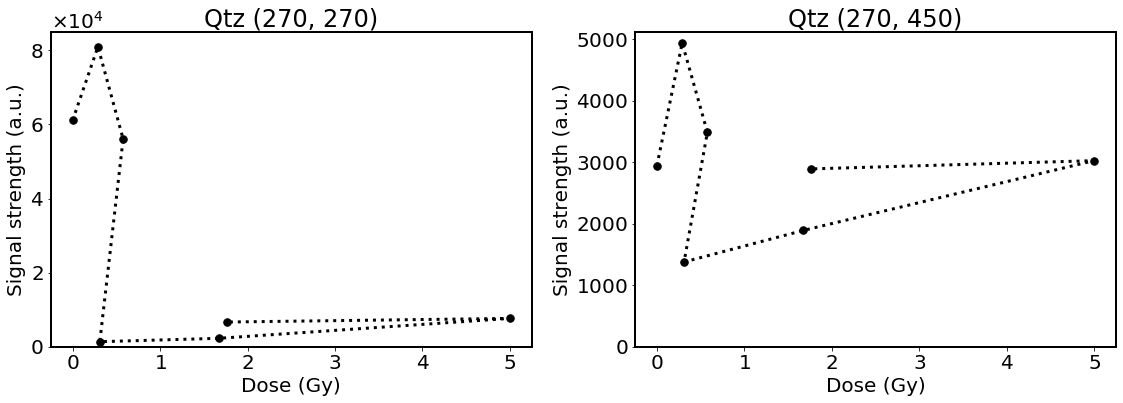

In [14]:
plt.figure(figsize=(16, 6))
d = dose.loc["Qtz"].dose

plt.subplot(1, 2, 1)
plot_dose(d, qtz_270_270, "Qtz", 270, 270)

plt.subplot(1, 2, 2)
plot_dose(d, qtz_270_450, "Qtz", 270, 450)

plt.tight_layout()

# LiF

In [36]:
crystal = "LiF"
datas = list(map(lambda x: load(x, crystal), lif_filenames))

(0, 300)

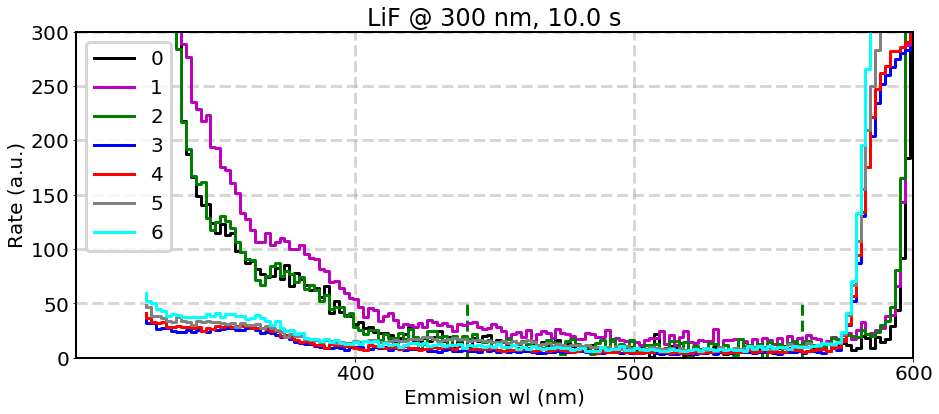

In [30]:
plt.figure(figsize=(15, 6))
plot_integrate(datas, crystal, 300, 10, (440, 560), (-5, 50))
plt.xlim(300, 600)
plt.ylim(0, 300)


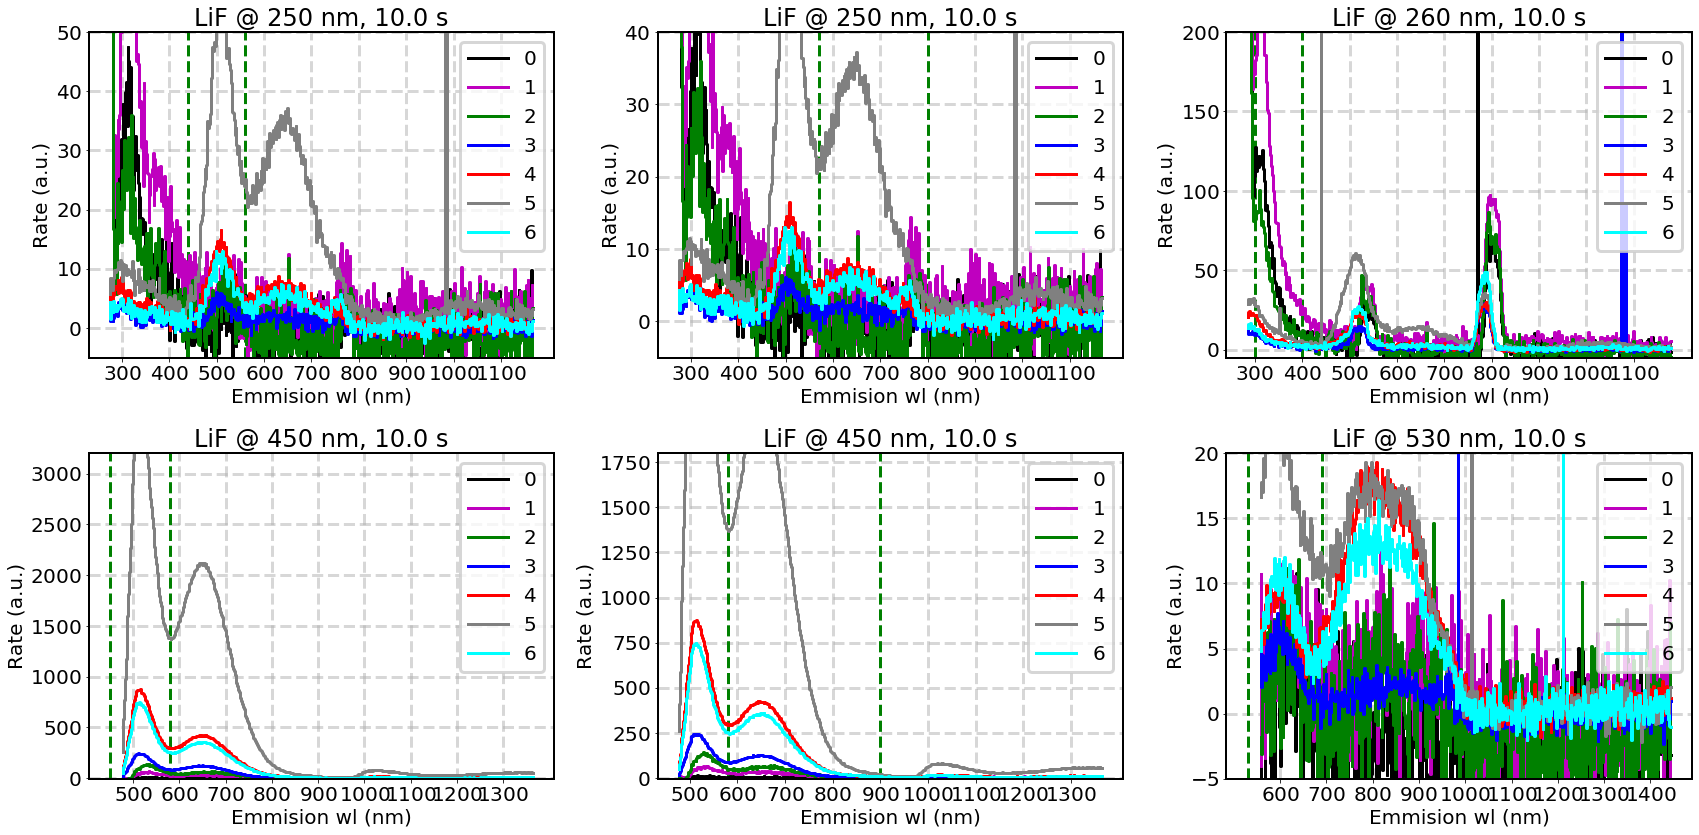

In [16]:
plt.figure(figsize=(24, 12))
plt.subplot(2, 3, 1)
lif_250_530 = plot_integrate(datas, crystal, 250, 10, (440, 560), (-5, 50))

plt.subplot(2, 3, 2)
lif_250_630 = plot_integrate(datas, crystal, 250, 10, (570, 800), (-5, 40))

plt.subplot(2, 3, 3)
lif_260_260 = plot_integrate(datas, crystal, 260, 10, (300, 400), (-5, 200))

plt.subplot(2, 3, 4)
lif_450_530 = plot_integrate(datas, crystal, 450, 10, (450, 580), (-5, 3200))

plt.subplot(2, 3, 5)
lif_450_680 = plot_integrate(datas, crystal, 450, 10, (580, 900), (-5, 1800))

plt.subplot(2, 3, 6)
#lif_530_810 = plot_integrate(datas, crystal, 530, 10, (670, 1050), (-5, 20))
lif_530_610 = plot_integrate(datas, crystal, 530, 10, (530, 690), (-5, 20))

plt.tight_layout()

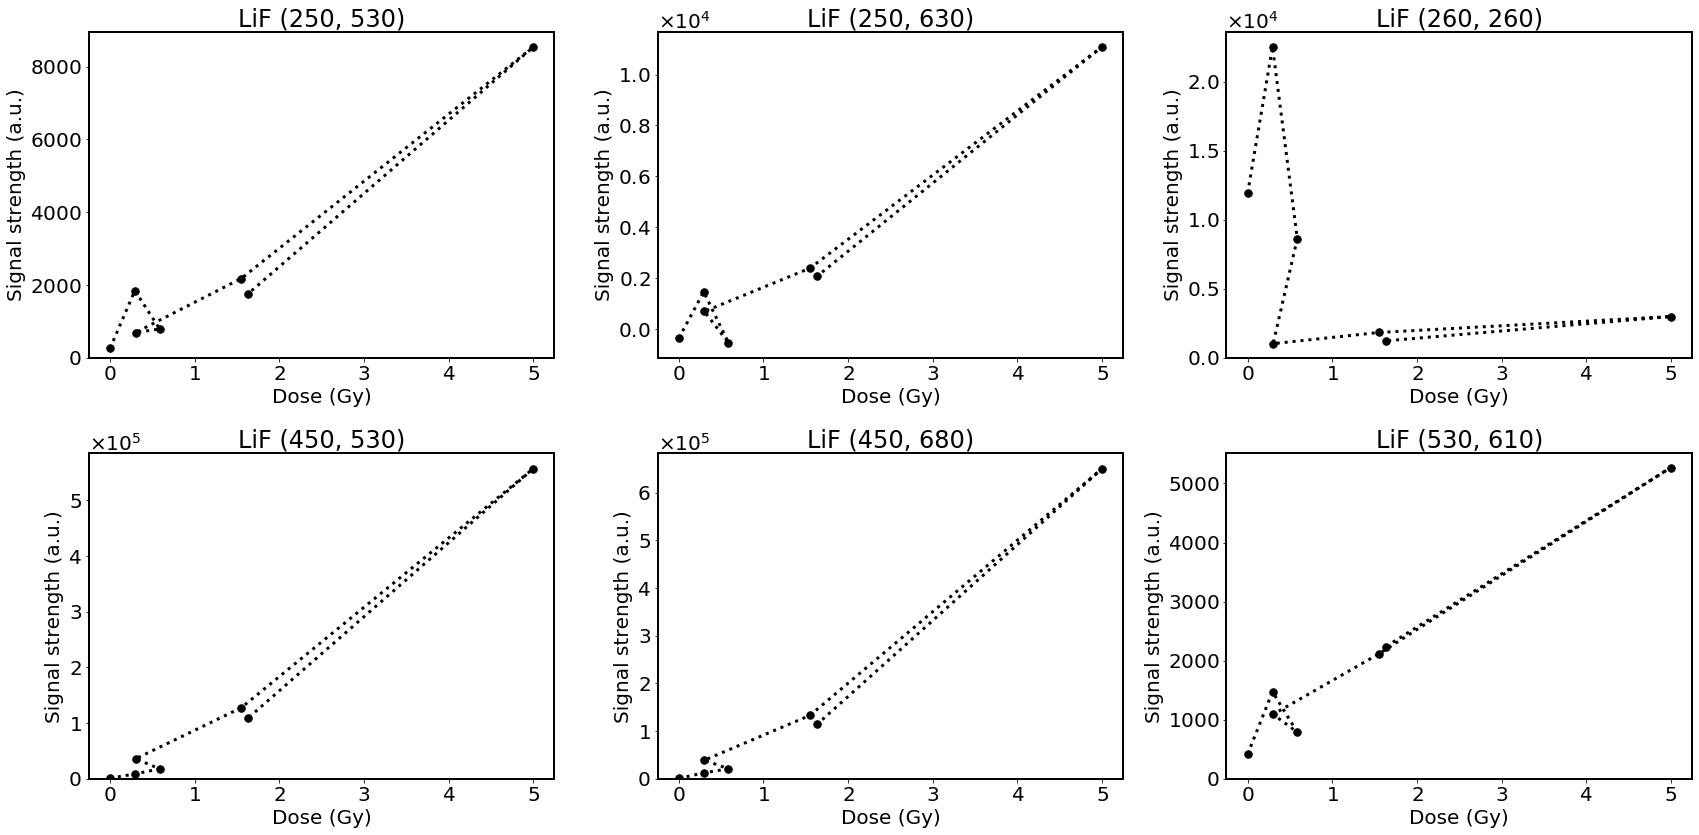

In [17]:
plt.figure(figsize=(24, 12))
d = dose.loc["LiF"].dose

plt.subplot(2, 3, 1)
plot_dose(d, lif_250_530, "LiF", 250, 530)

plt.subplot(2, 3, 2)
plot_dose(d, lif_250_630, "LiF", 250, 630)

plt.subplot(2, 3, 3)
plot_dose(d, lif_260_260, "LiF", 260, 260)

plt.subplot(2, 3, 4)
plot_dose(d, lif_450_530, "LiF", 450, 530)

plt.subplot(2, 3, 5)
plot_dose(d, lif_450_680, "LiF", 450, 680)

plt.subplot(2, 3, 6)
#plot_dose(d, lif_530_810, "LiF", 530, 810)
plot_dose(d, lif_530_610, "LiF", 530, 610)

plt.tight_layout()

# MgF

In [31]:
crystal = "MgF"
datas = list(map(lambda x: load(x, crystal), mgf_filenames))

(0, 3000)

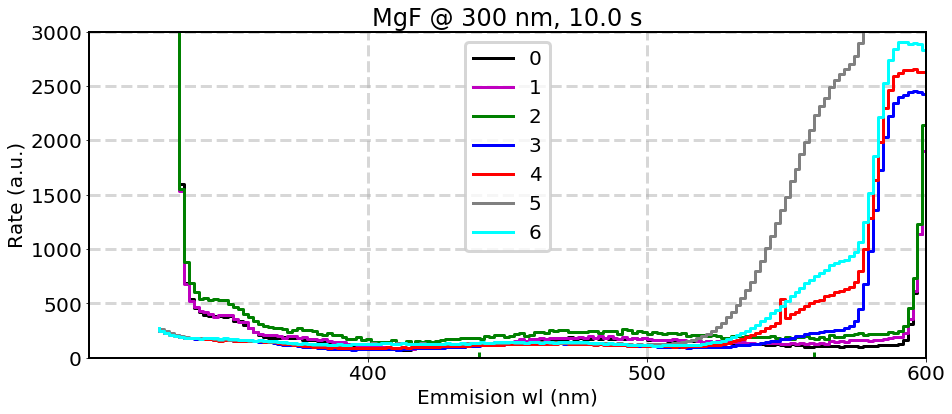

In [35]:
plt.figure(figsize=(15, 6))
plot_integrate(datas, crystal, 300, 10, (440, 560), (-5, 50))
plt.xlim(300, 600)
plt.ylim(0, 3000)


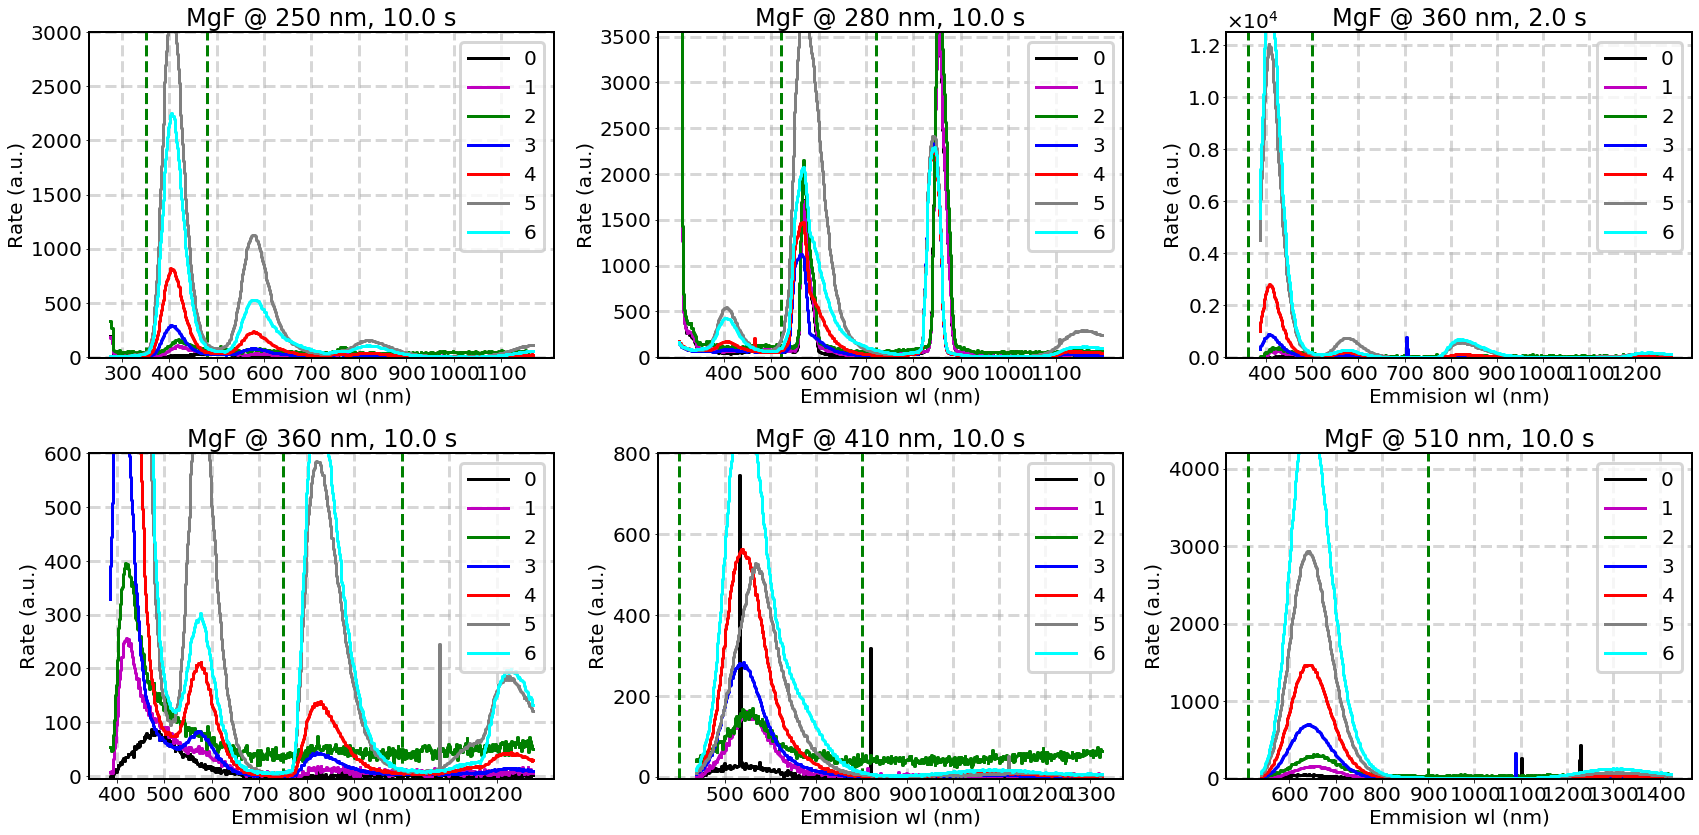

In [19]:
plt.figure(figsize=(24, 12))
plt.subplot(2, 3, 1)
mgf_250_410 = plot_integrate(datas, crystal, 250, 10, (350, 480), (-5, 3000))

plt.subplot(2, 3, 2)
mgf_280_580 = plot_integrate(datas, crystal, 280, 10, (520, 720), (-5, 3550))

plt.subplot(2, 3, 3)
mgf_360_410 = plot_integrate(datas, crystal, 360,  2, (360, 500), (-5, 12500))

plt.subplot(2, 3, 4)
mgf_360_830 = plot_integrate(datas, crystal, 360, 10, (750, 1000), (-5, 600))

plt.subplot(2, 3, 5)
mgf_410_580 = plot_integrate(datas, crystal, 410, 10, (400, 800), (-5, 800))

plt.subplot(2, 3, 6)
mgf_510_650 = plot_integrate(datas, crystal, 510, 10, (510, 900), (-5, 4200))

plt.tight_layout()

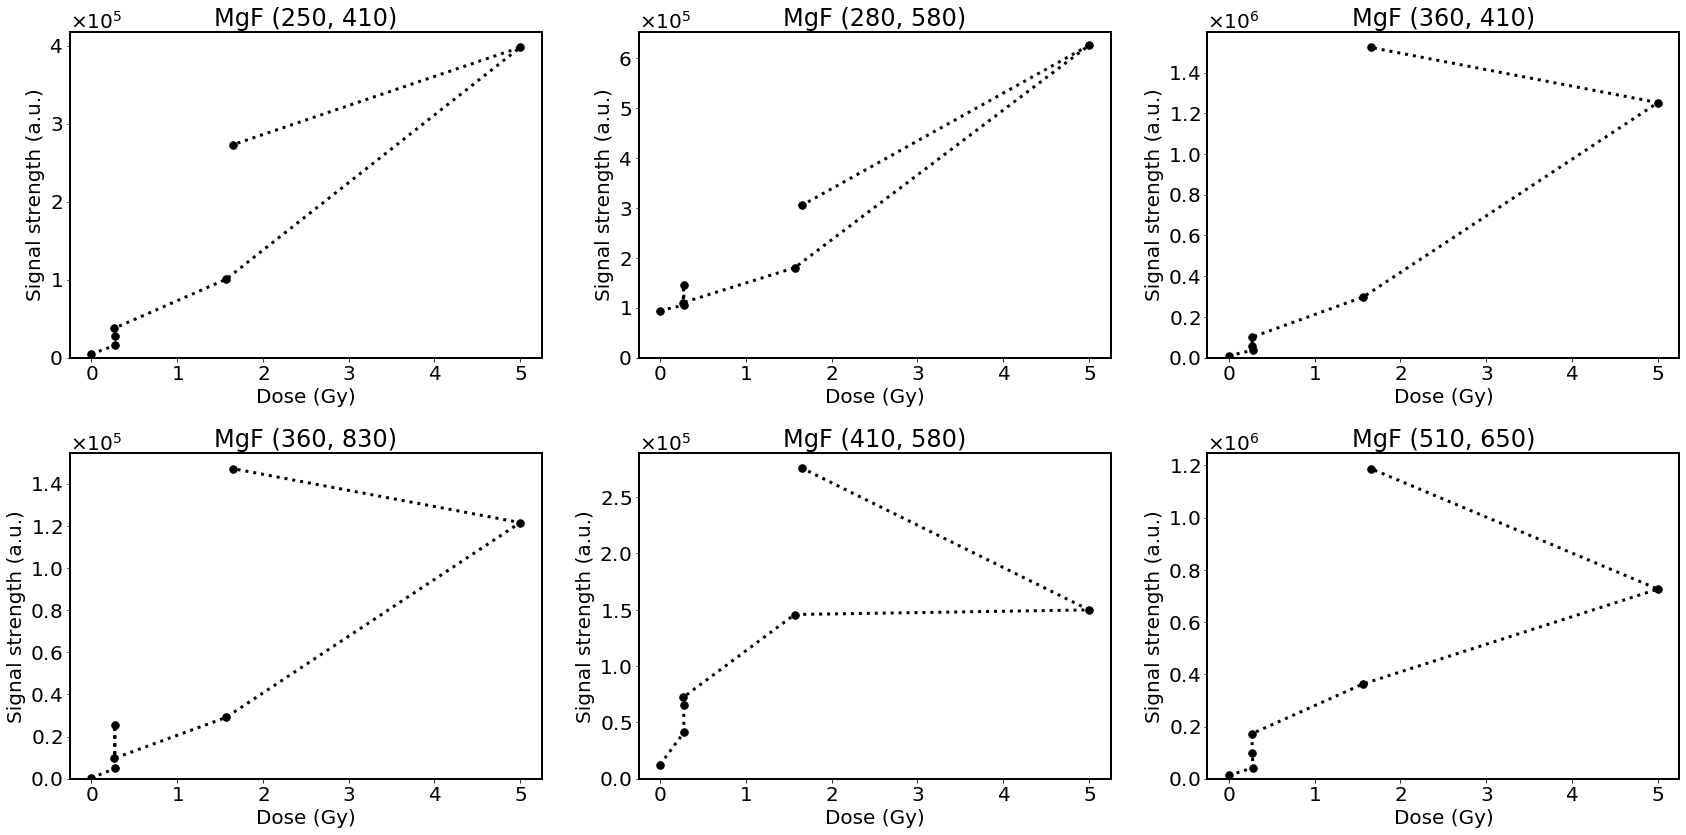

In [22]:
plt.figure(figsize=(24, 12))
d = dose.loc["MgF"].dose

plt.subplot(2, 3, 1)
plot_dose(d, mgf_250_410, "MgF", 250, 410, cumulative=True)

plt.subplot(2, 3, 2)
plot_dose(d, mgf_280_580, "MgF", 280, 580)

plt.subplot(2, 3, 3)
plot_dose(d, mgf_360_410, "MgF", 360, 410)

plt.subplot(2, 3, 4)
plot_dose(d, mgf_360_830, "MgF", 360, 830)

plt.subplot(2, 3, 5)
plot_dose(d, mgf_410_580, "MgF", 410, 580)

plt.subplot(2, 3, 6)
plot_dose(d, mgf_510_650, "MgF", 510, 650)

plt.tight_layout()

# Fits

ValueError: operands could not be broadcast together with shapes (4,) (5,) 

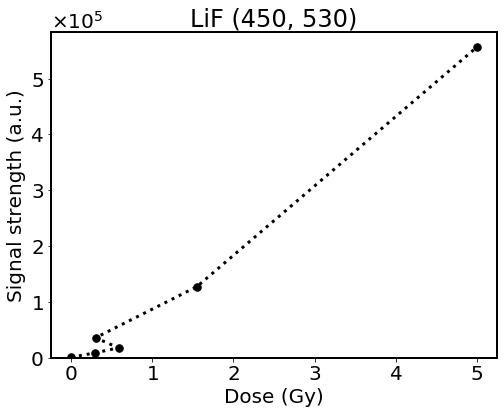

In [21]:
d = dose.loc["LiF"].dose
plot_dose(d[:-1], lif_450_530[:-1], "LiF", 450, 530)

from CCfit import fit, polynom

x1 = [0, *d[:2]]
x2 = [0, *d[2:-1]]
y1 = [0, *lif_450_530[:2]]
y2 = [*lif_450_530[1:-1]]

f1 = fit(polynom, x1, y1, (0, 1))
f2 = fit(polynom, x2, y2, (0, 1))

plt.plot(x1, f1.fn(x1), "r-")
plt.plot(x2, f2.fn(x2), "r-")
print(f1.values, f2.values)

In [ ]:
d = dose.loc["LiF"].dose
plot_dose(d[:-1], lif_450_680[:-1], "LiF", 450, 680)

from CCfit import fit, polynom

x1 = [0, *d[:2]]
x2 = [0, *d[2:-1]]
y1 = [0, *lif_450_680[:2]]
y2 = [*lif_450_680[1:-1]]

f1 = fit(polynom, x1, y1, (0, 1))
f2 = fit(polynom, x2, y2, (0, 1))

plt.plot(x1, f1.fn(x1), "r-")
plt.plot(x2, f2.fn(x2), "r-")
print(f1.values, f2.values)

In [ ]:
d = dose.loc["LiF"].dose
s = np.array(lif_450_530) + np.array(lif_450_680)
plot_dose(d.cumsum(), s, "LiF", 450, "450 + 680")

x1 = [0, *d.cumsum()]
y1 = [0, *s]

f1 = fit(polynom, x1, y1, (0, 1))
plt.plot(x1, f1.fn(x1), "r-")
f1.values

In [ ]:
d = dose.loc["LiF"].dose
s = np.array(lif_450_530) + np.array(lif_450_680)
plot_dose(d, s, "LiF", 450, "450 + 680")

In [ ]:
dose.loc["MgF"].dose

In [ ]:
d = dose.loc["MgF"].irrad_no.values
plot_dose(d[:3], mgf_250_410[:3], "MgF", 250, 410)
plt.xlabel("Irrad #")
plt.xticks(np.arange(4))

from CCfit import fit, polynom

x = np.arange(4)
y = [0, *mgf_250_410[:3]]
f = fit(polynom, x, y, (0, 1))

plt.plot(x, f.fn(x), "r-")
f.values

In [ ]:
d = dose.loc["MgF"].irrad_no.values
plot_dose(d[:3], mgf_410_580[:3], "MgF", 410, 580)
plt.xlabel("Irrad #")
plt.xticks(np.arange(4))

from CCfit import fit, polynom

x = np.arange(4)
y = [0, *mgf_410_580[:3]]
f = fit(polynom, x, y, (0, 1))

plt.plot(x, f.fn(x), "r-")

In [ ]:
d = dose.loc["MgF"].irrad_no.values
plot_dose(d[:3], mgf_510_650[:3], "MgF", 510, 650)
plt.xlabel("Irrad #")
plt.xticks(np.arange(4))

from CCfit import fit, polynom

x = np.arange(4)
y = [0, *mgf_510_650[:3]]
f = fit(polynom, x, y, (0, 1))

plt.plot(x, f.fn(x), "r-")

In [ ]:
x = np.arange(1, 4)
y = x * 1.5 - 0.2
plt.plot(x, y, ".", label="before")

x = np.arange(1, 4)
y = x**0.8 * 1.8 + 0.1
plt.plot(x, y, ".", label="after")

plt.xlabel("Dose (a.u.)")
plt.ylabel("Signal strength (a.u.)")
plt.legend()

In [ ]:
x = np.arange(1, 4)
y = np.ones(3)
plt.plot(x, y, ".", label="curing")

x = np.arange(1, 4)
y = 0.9 + 0.1* x
plt.plot(x, y, ".", label="emptying")

plt.ylim(0.8, 1.5)
plt.xlabel("Irrad #")
plt.xticks(x)
plt.ylabel("Signal strength (a.u.)")
plt.legend()

In [ ]:
crystal = "LiF"
c       = crystal if crystal != "Qtz" else "Qz"
datas = list(map(lambda x: load(x, c), eval(f"{crystal.lower()}_filenames")))

In [ ]:
exposure =  10
ex_wl    = 450
rebin    =   8

for k, data in enumerate(datas):
    data     = filter_df(data, exposure=exposure, ex_wl=ex_wl, grating_mono = 1 + int(ex_wl >= 400))

    data = rebin_df(data, rebin)
    plot1d(data.em_wl, data.rate / normalization(data.timestamp), ylabel="Rate (a.u.)", label=str(k))

plt.title(f"{crystal} @ {ex_wl} nm, {exposure:.1f} s")
plt.ylim(-5, 20)
plt.legend(title="irrad#")